In [ ]:
!pip install -q ultralytics tqdm lxml matplotlib albumentations torchvision

import os
import shutil
import xml.etree.ElementTree as ET
from tqdm import tqdm
from PIL import Image
import torchvision
from ultralytics import YOLO
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch


In [ ]:
class Config:
    VOC_YEAR = "2012"
    VOC_ROOT = "./VOCdevkit/VOC2012"
    OUTPUT_ROOT = "./dataset"
    MODEL_TYPE = "yolov8n.pt"
    CLASSES = [
        'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat',
        'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person',
        'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
    ]

Config.TRAINING_CONFIG = Config.TRAINING_CONFIG = {
    'data': "voc.yaml",
    'batch': 16,
    'imgsz': 1024,
    'lr0': 0.001,
    'lrf': 0.02,
    'optimizer': "SGD",
    'momentum': 0.937,
    'weight_decay': 0.0005,
    'augment': True,
    'verbose': True,
    'workers': 4,
    'patience': 15,
    'save': True
}



In [ ]:
def prepare_dataset():
    torchvision.datasets.VOCDetection(root=".", year=Config.VOC_YEAR, image_set="train", download=True)
    for dir_path in [f"{Config.OUTPUT_ROOT}/images/train", f"{Config.OUTPUT_ROOT}/images/val",
                     f"{Config.OUTPUT_ROOT}/labels/train", f"{Config.OUTPUT_ROOT}/labels/val"]:
        os.makedirs(dir_path, exist_ok=True)

prepare_dataset()


In [ ]:
def convert_annotation(xml_path, txt_path, img_size):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    with open(txt_path, 'w') as f:
        for obj in root.findall('object'):
            cls_name = obj.find('name').text
            if cls_name not in Config.CLASSES:
                continue
            cls_id = Config.CLASSES.index(cls_name)
            bbox = obj.find('bndbox')
            coords = [int(bbox.find(dim).text) for dim in ['xmin', 'ymin', 'xmax', 'ymax']]
            x_center = (coords[0] + coords[2]) / 2 / img_size[0]
            y_center = (coords[1] + coords[3]) / 2 / img_size[1]
            width = (coords[2] - coords[0]) / img_size[0]
            height = (coords[3] - coords[1]) / img_size[1]
            f.write(f"{cls_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")


In [ ]:
from tqdm import tqdm
def process_data_split(split_name, limit=None):
    split_file = os.path.join(Config.VOC_ROOT, 'ImageSets/Main', f'{split_name}.txt')
    with open(split_file, 'r') as f:
        image_ids = [line.strip() for line in f.readlines()]
    if limit:
        image_ids = image_ids[:limit]
    for img_id in tqdm(image_ids, desc=f"Processing {split_name}"):
        img_src = os.path.join(Config.VOC_ROOT, 'JPEGImages', f'{img_id}.jpg')
        xml_src = os.path.join(Config.VOC_ROOT, 'Annotations', f'{img_id}.xml')
        img_dest = os.path.join(Config.OUTPUT_ROOT, f'images/{split_name}', f'{img_id}.jpg')
        label_dest = os.path.join(Config.OUTPUT_ROOT, f'labels/{split_name}', f'{img_id}.txt')
        shutil.copy(img_src, img_dest)
        with Image.open(img_src) as img:
            convert_annotation(xml_src, label_dest, img.size)

process_data_split("train", limit=500)
process_data_split("val", limit=100)


Processing val: 100%|██████████| 100/100 [00:00<00:00, 1629.17it/s]


In [ ]:
def create_yaml_config():
    yaml_content = f"""\
path: {Config.OUTPUT_ROOT}
train: images/train
val: images/val
names: {dict(enumerate(Config.CLASSES))}
"""
    with open("voc.yaml", "w") as f:
        f.write(yaml_content)

create_yaml_config()


In [ ]:
def train_model():
    model = YOLO(Config.MODEL_TYPE)
    device = 0 if torch.cuda.is_available() else 'cpu'
    print(f"Training on device: {device}")
    Config.TRAINING_CONFIG['device'] = device
    results = model.train(**Config.TRAINING_CONFIG)
    return results

results = train_model()


Training on device: 0
Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=voc.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.02, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=SGD, overlap_mask=True, patience=15, perspective=0.0, plots=True, pose=12.0, pretrained=

train: Scanning /content/dataset/labels/train.cache... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 491.2±523.6 MB/s, size: 87.4 KB)


val: Scanning /content/dataset/labels/val.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: SGD(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      5.35G      1.134      4.305      1.481         15       1024: 100%|██████████| 32/32 [00:22<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]

                   all        100        239   0.000147     0.0423     0.0104     0.0062



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      6.52G      1.086      3.858       1.48         17       1024: 100%|██████████| 32/32 [00:18<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.35it/s]

                   all        100        239     0.0502     0.0474     0.0541     0.0339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      6.52G      1.083      3.484      1.478         33       1024: 100%|██████████| 32/32 [00:18<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]

                   all        100        239      0.888     0.0237     0.0371     0.0244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40      6.52G      1.031      3.198      1.411         23       1024: 100%|██████████| 32/32 [00:18<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.95it/s]

                   all        100        239      0.942     0.0373     0.0787      0.054



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40      6.52G      1.022      3.105      1.436         26       1024: 100%|██████████| 32/32 [00:17<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]


                   all        100        239      0.979     0.0472      0.107     0.0741

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40      6.52G      1.018      2.892      1.393         19       1024: 100%|██████████| 32/32 [00:18<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]

                   all        100        239      0.622       0.11       0.15      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40      6.52G      1.009       2.84      1.391         26       1024: 100%|██████████| 32/32 [00:18<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


                   all        100        239      0.552      0.148      0.189      0.124

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40      6.52G      1.011      2.784      1.413         27       1024: 100%|██████████| 32/32 [00:17<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  2.00it/s]


                   all        100        239      0.677      0.211       0.26      0.174

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40      6.52G      0.964      2.619      1.369         17       1024: 100%|██████████| 32/32 [00:19<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.05it/s]


                   all        100        239      0.656      0.281      0.309      0.207

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40      6.52G     0.9622      2.556      1.379         21       1024: 100%|██████████| 32/32 [00:18<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.41it/s]

                   all        100        239       0.74      0.274      0.341      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40      6.52G     0.9965      2.478      1.373         17       1024: 100%|██████████| 32/32 [00:19<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]

                   all        100        239      0.725      0.362      0.377      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40      6.52G     0.9448      2.297      1.354         29       1024: 100%|██████████| 32/32 [00:19<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.98it/s]


                   all        100        239      0.731      0.352      0.392      0.245

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40      6.52G     0.9586      2.275      1.355         37       1024: 100%|██████████| 32/32 [00:18<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.33it/s]


                   all        100        239      0.769      0.295      0.385      0.257

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40      6.52G     0.9667       2.22      1.335         27       1024: 100%|██████████| 32/32 [00:18<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.92it/s]

                   all        100        239      0.739      0.357      0.424      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40      6.52G     0.9613      2.183      1.344         24       1024: 100%|██████████| 32/32 [00:18<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.95it/s]

                   all        100        239        0.7      0.379      0.439      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40      6.52G     0.9539      2.164      1.361         26       1024: 100%|██████████| 32/32 [00:18<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]


                   all        100        239      0.702      0.395      0.462      0.307

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40      6.52G     0.9059      2.051      1.322         19       1024: 100%|██████████| 32/32 [00:18<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.93it/s]


                   all        100        239      0.808      0.387       0.51      0.337

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40      6.52G     0.9238      2.089      1.348         28       1024: 100%|██████████| 32/32 [00:18<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


                   all        100        239      0.768      0.372      0.505      0.328

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40      6.52G     0.9242      2.009      1.337         43       1024: 100%|██████████| 32/32 [00:18<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.37it/s]

                   all        100        239      0.829      0.371      0.513      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40      6.52G     0.9228       1.97      1.303         22       1024: 100%|██████████| 32/32 [00:18<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]


                   all        100        239      0.852      0.362      0.518      0.352

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40      6.52G     0.9043      2.016      1.313         21       1024: 100%|██████████| 32/32 [00:19<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


                   all        100        239      0.808      0.398      0.534      0.353

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40      6.52G     0.9095      1.945      1.326         32       1024: 100%|██████████| 32/32 [00:18<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.38it/s]

                   all        100        239      0.755      0.416      0.531      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40      6.52G     0.8844      1.914      1.299         23       1024: 100%|██████████| 32/32 [00:18<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.78it/s]

                   all        100        239      0.765      0.413      0.533      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40      6.52G     0.8759      1.885      1.281         34       1024: 100%|██████████| 32/32 [00:19<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]


                   all        100        239      0.641      0.447      0.534       0.36

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40      6.52G      0.891       1.89      1.303         29       1024: 100%|██████████| 32/32 [00:18<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]

                   all        100        239      0.639      0.495       0.54      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40      6.52G     0.8872      1.837      1.286         18       1024: 100%|██████████| 32/32 [00:18<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]


                   all        100        239      0.537      0.554      0.552      0.378

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40      6.52G     0.8914      1.876      1.294         36       1024: 100%|██████████| 32/32 [00:19<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]


                   all        100        239      0.723       0.46       0.56      0.387

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40      6.52G     0.8386       1.83      1.261         20       1024: 100%|██████████| 32/32 [00:18<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.40it/s]


                   all        100        239      0.713       0.48      0.568      0.391

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40      6.52G     0.8937      1.841      1.288         22       1024: 100%|██████████| 32/32 [00:18<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]


                   all        100        239      0.707      0.469      0.567      0.387

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40      6.52G     0.8481      1.806      1.282         37       1024: 100%|██████████| 32/32 [00:19<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


                   all        100        239      0.549      0.544      0.576      0.386
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40      6.52G      1.024      2.558      1.375         12       1024: 100%|██████████| 32/32 [00:21<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.94it/s]

                   all        100        239      0.631        0.5      0.562      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40      6.52G     0.9599      2.539      1.341          9       1024: 100%|██████████| 32/32 [00:17<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


                   all        100        239      0.478      0.555       0.54      0.353

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40      6.52G     0.9714      2.554      1.349          8       1024: 100%|██████████| 32/32 [00:17<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.93it/s]


                   all        100        239      0.604      0.489       0.55      0.363

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40      6.52G     0.9305      2.453      1.329         14       1024: 100%|██████████| 32/32 [00:16<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]


                   all        100        239      0.599      0.479      0.538      0.361

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40      6.52G     0.9259      2.399      1.331         18       1024: 100%|██████████| 32/32 [00:17<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]

                   all        100        239      0.637      0.468      0.569      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40      6.52G     0.9438      2.453      1.329         11       1024: 100%|██████████| 32/32 [00:16<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.70it/s]


                   all        100        239      0.661      0.464      0.562      0.376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40      6.52G     0.9118      2.454      1.316          6       1024: 100%|██████████| 32/32 [00:17<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]

                   all        100        239      0.657      0.501      0.575      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40      6.52G      0.952      2.455      1.321          9       1024: 100%|██████████| 32/32 [00:16<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.44it/s]

                   all        100        239      0.637      0.497      0.566      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40      6.52G     0.8961       2.35      1.307         17       1024: 100%|██████████| 32/32 [00:17<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.00it/s]


                   all        100        239      0.633       0.53      0.578      0.382

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40      6.52G     0.8764      2.341       1.28          9       1024: 100%|██████████| 32/32 [00:16<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.37it/s]

                   all        100        239      0.684      0.487      0.591      0.394



40 epochs completed in 0.238 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 6.3MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,009,548 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.46s/it]


                   all        100        239      0.709      0.582      0.651      0.483
             aeroplane          4          6      0.518        0.5      0.523      0.324
               bicycle          3          4      0.682      0.546      0.735      0.581
                  bird          4          8      0.638       0.75      0.666        0.5
                  boat          5          7      0.293      0.143       0.28      0.188
                bottle          6          9      0.794      0.431      0.617      0.406
                   bus          2          2          1          0          0          0
                   car         14         24      0.631      0.714      0.778      0.575
                   cat         10         10      0.879        0.8      0.838      0.566
                 chair         10         18      0.636      0.583      0.659      0.408
                   cow          2          3       0.94          1      0.995      0.929
           diningtabl

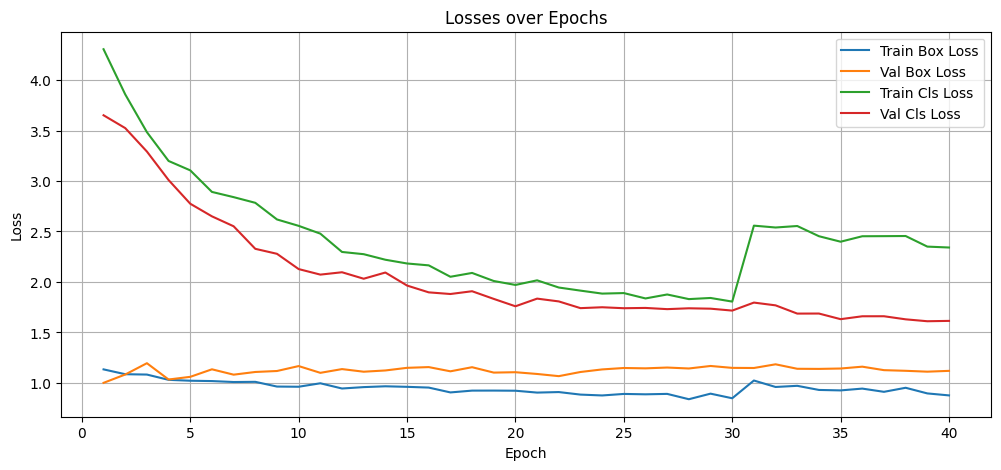

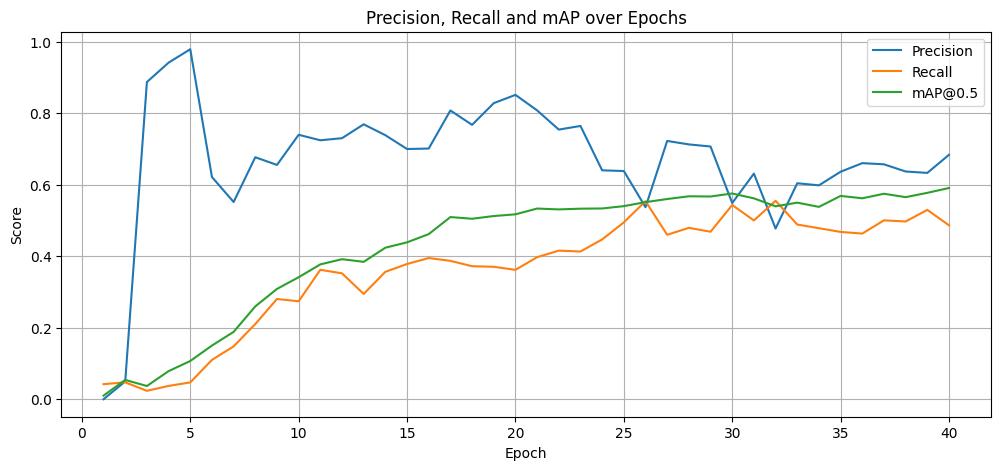

Final Precision: 0.6841
Final Recall: 0.4868
Final mAP50: 0.5912


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/content/runs/detect/train2/results.csv')

plt.figure(figsize=(12,5))
plt.plot(df['epoch'], df['train/box_loss'], label='Train Box Loss')
plt.plot(df['epoch'], df['val/box_loss'], label='Val Box Loss')
plt.plot(df['epoch'], df['train/cls_loss'], label='Train Cls Loss')
plt.plot(df['epoch'], df['val/cls_loss'], label='Val Cls Loss')
plt.title('Losses over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(12,5))
plt.plot(df['epoch'], df['metrics/precision(B)'], label='Precision')
plt.plot(df['epoch'], df['metrics/recall(B)'], label='Recall')
plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@0.5')
plt.title('Precision, Recall and mAP over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.grid()
plt.show()

print(f"Final Precision: {df['metrics/precision(B)'].iloc[-1]:.4f}")
print(f"Final Recall: {df['metrics/recall(B)'].iloc[-1]:.4f}")
print(f"Final mAP50: {df['metrics/mAP50(B)'].iloc[-1]:.4f}")


Saving 2008_000646.jpg to 2008_000646 (1).jpg

image 1/1 /content/2008_000646.jpg: 704x1024 1 person, 39.4ms
Speed: 4.5ms preprocess, 39.4ms inference, 8.2ms postprocess per image at shape (1, 3, 704, 1024)


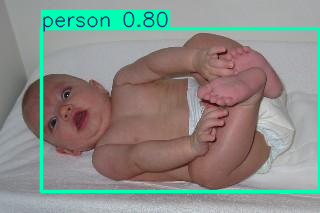

In [ ]:
from google.colab import files
uploaded = files.upload()

from ultralytics import YOLO
from PIL import Image
import matplotlib.pyplot as plt

model = YOLO("/content/runs/detect/train2/weights/best.pt")

image_path = "2008_000646.jpg"

results = model(image_path)

results[0].show()

Saving 2008_000480.jpg to 2008_000480.jpg

image 1/1 /content/2008_000480.jpg: 768x1024 4 persons, 60.4ms
Speed: 9.0ms preprocess, 60.4ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


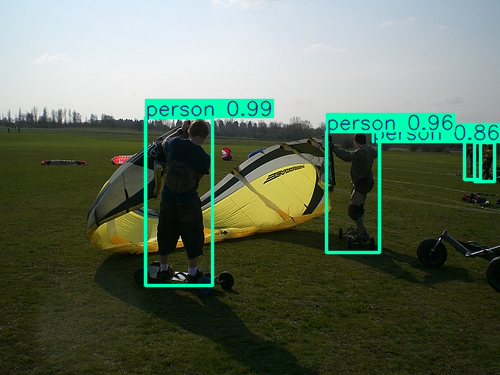

In [ ]:
from google.colab import files
uploaded = files.upload()

from ultralytics import YOLO
from PIL import Image
import matplotlib.pyplot as plt

model = YOLO("/content/runs/detect/train2/weights/best.pt")

image_path = "2008_000480.jpg"

results = model(image_path)

results[0].show()